In [1]:
# MLB Attendance Data - DATA 301 Final Project

In [116]:
import requests
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import bs4
import time
import json
import math

In [3]:
team_names = {"ARI": ["ARI"],
              "ATL": ["ATL", "MLN", "BSN"], 
              "BAL": ["BAL", "SLB", "MLA"], 
              "BOS": ["BOS"], 
              "CHC": ["CHC"], 
              "CHW": ["CHW"], 
              "CIN": ["CIN"], 
              "CLE": ["CLE"], 
              "COL": ["COL"], 
              "DET": ["DET"], 
              "HOU": ["HOU"], 
              "KCR": ["KCR"], 
              "LAA": ["LAA", "ANA", "CAL"], 
              "LAD": ["LAD", "BRO"], 
              "MIA": ["MIA", "FLA"], 
              "MIL": ["MIL", "SEP"],
              "MIN": ["MIN", "WSH"], 
              "NYM": ["NYM"],
              "NYY": ["NYY"],
              "OAK": ["OAK", "KCA", "PHA"],
              "PHI": ["PHI"],
              "PIT": ["PIT"],
              "SDP": ["SDP"],
              "SFG": ["SFG", "NYG"], 
              "SEA": ["SEA"], 
              "STL": ["STL"], 
              "TBD": ["TBD", "TBR"],
              "TEX": ["TEX", "WSA"], 
              "TOR": ["TOR"],
              "WSN": ["WSN", "MON"]
              }

teams = dict.fromkeys(team_names)
reverse_lookup = dict( (v, k) for k in team_names for v in team_names[k] )

mlb = {
    "American": {
        "East": ["BAL", "BOS", "NYY", "TOR", "TBD"], 
        "Central": ["CHW", "CLE", "DET", "KCR", "MIN"], 
        "West": ["HOU", "LAA", "OAK", "SEA", "TEX"],
    },
    "National": {
        "East": ["ATL", "MIA", "NYM", "PHI", "WSN"], 
        "Central": ["CIN", "CHC", "MIL", "PIT", "STL"], 
        "West": ["ARI", "COL", "LAD", "SDP", "SFG"],
    },
}

div = {
          "ARI": "NW",
          "ATL": "NE", 
          "BAL": "AE", 
          "BOS": "AE", 
          "CHC": "NC", 
          "CHW": "AC", 
          "CIN": "NC", 
          "CLE": "AC", 
          "COL": "NW", 
          "DET": "AC", 
          "HOU": "AW", 
          "KCR": "AC", 
          "LAA": "AW", 
          "LAD": "NW", 
          "MIA": "NE", 
          "MIL": "NC",
          "MIN": "AC", 
          "NYM": "NE",
          "NYY": "AE",
          "OAK": "AW",
          "PHI": "NE",
          "PIT": "NC",
          "SDP": "NW",
          "SFG": "NW", 
          "SEA": "AW", 
          "STL": "NC", 
          "TBD": "AE",
          "TEX": "AW", 
          "TOR": "AE",
          "WSN": "NE",
        }

In [ ]:
for key in team_names.keys():
    games = []
    print(key)
    for year in range(2000,2016):
        for team in team_names[key]:
            url = "http://www.baseball-reference.com/teams/" + team + "/" + str(year) + "-schedule-scores.shtml"
            page = requests.get(url)
            season = BeautifulSoup(page.text, "html.parser")

            table = season.find("div", {"id": "div_team_schedule"},class_="table_container")
            if table is not None:
                table = table.find_all("tr", class_="")
                for row in table[1:-1]:
                    if "thead" not in row["class"]:
                        values = row.find_all("td")
                        games.append({
                                "Date": values[2].text.split()[2] + " " + values[2].text.split(" ")[1] + " " + str(year),
                                "Year": year,
                                "DOW" : values[2].text.split(" ")[0][0:-1],
                                "Month" : values[2].text.split(" ")[1],
                                "Opp" : values[6].text,
                                "W/L" : values[7].text[0],
                                "Game" : values[1].text,
                                "WO" : "Y" if len(values[7].text) > 1 else "N",
                                "GB" : 0 if "Tied" in values[13].text 
                                        else (values[13].text).replace(" ", "").replace("up", "-"),
                                "Time" : values[18].text,
                                "Attendance" : values[19].text.replace(",", ""),
                                "Streak" : len(values[20].text),
                                "Home" : values[5].text,
                                "Pct" : 0 if (float(values[11].text.split("-")[0]) + float(values[11].text.split("-")[1])) == 0 
                                            else float(values[11].text.split("-")[0]) / (float(values[11].text.split("-")[0]) + float(values[11].text.split("-")[1])),
                                "RS" : int(values[8].text),
                                "RA" : int(values[9].text),
                                "Pitcher" : (values[14].find("a")["title"] if values[14].find("a") is not None else "") 
                                            if values[7].text[0] == "W" else (values[15].find("a")["title"] if values[15].find("a") is not None else ""),
                                "OPitcher" : (values[15].find("a")["title"] if values[15].find("a") is not None else "") 
                                            if values[7].text[0] == "W" else (values[14].find("a")["title"] if values[14].find("a") is not None else ""),
                                "Team" : team,
                            })
                break

            time.sleep(0.1)
    d = pd.DataFrame(games)
    if "Attendance" in d:
        d["Attendance"] = pd.to_numeric(d["Attendance"])
    teams[team] = d

### REFRESH DATA:

In [4]:
# LOAD JSON FILES TO NOTEBOOK
for team in teams.keys():
    with open(team + '.json', 'r') as f:
        try:
            teams[team] = pd.read_json( json.load(f) )
        # if the file is empty the ValueError will be thrown
        except ValueError:
            teams[team] = {}

In [5]:
# CLEANING UP THE MESS THAT IS THE TAMPA BAY RAYS
if "TBR" in teams:
    teams["TBD"] = teams["TBR"] 
    del teams["TBR"]

In [ ]:
# FOR SAVING JSON FILES
# for team in teams.keys():
#     with open(team + '.json', 'w') as f:
#             json.dump(teams[team].to_json(), f)

In [6]:
for team in teams.keys():
    teams_for_years = []
    for year in range(2000, 2016):
        team_for_year = teams[team][teams[team]["Year"] == year].copy()
        team_for_year["RA_Z"] = team_for_year["RA"].rolling(center=False, window=162, min_periods=1).sum()
        team_for_year["RS_Z"] = team_for_year["RS"].rolling(center=False, window=162, min_periods=1).sum()
        teams_for_years.append(team_for_year)
    teams[team] = pd.concat(teams_for_years, axis=0)

In [7]:
away = teams.copy()

for team in teams.keys():
    temp = teams[team]
    temp_away = away[team]
    
    temp["OVERALL_GAME"] = pd.to_numeric(temp.reset_index()["index"]) + 1
    temp["Date"] = pd.to_datetime(temp["Date"], format='%d %b %Y')
    temp["Year-DT"] = temp["Year"].apply(str) 
    temp["Year-DT"] = pd.to_datetime( temp["Year-DT"], format='%Y' )
    temp_away = temp[temp["Home"] == "@"]
    temp = temp[temp["Home"] != "@"]
    temp.fillna(0)
    temp_away.fillna(0)
    away[team] = temp_away
    teams[team] = temp


In [8]:
ALL = pd.DataFrame()
ALL_AWAY = pd.DataFrame()

for team in teams.keys():
    ALL = pd.concat([ALL, teams[team]], axis=0)
    ALL_AWAY = pd.concat([ALL_AWAY, away[team]], axis=0)

In [9]:
for abbrev in reverse_lookup.keys():
    ALL = ALL.replace(abbrev, reverse_lookup[abbrev])
    ALL_AWAY = ALL_AWAY.replace(abbrev, reverse_lookup[abbrev])
    for team in teams.keys():
        teams[team] = teams[team].replace(abbrev, reverse_lookup[abbrev])
        away[team] = away[team].replace(abbrev, reverse_lookup[abbrev])

In [32]:
ALL_MERGE = pd.merge(ALL, ALL_AWAY, left_on=["Date", "Team", "Time"], right_on=["Date", "Opp", "Time"])
ALL_MERGE = ALL_MERGE[["Attendance_x", "Team_x", "Opp_x", "DOW_x", "GB_x", "GB_y", "Month_x", "Pitcher_x", 
        "OPitcher_x", "Pct_x", "Pct_y", "RA_x", "RS_x", "Streak_x", "Streak_y", "W/L_x", "WO_x", 
        "Game_x", "Time", "Date", "Year_x", "RA_Z_x", "RS_Z_x", "RA_Z_y", "RS_Z_y"]]

In [33]:
def same_divison (r):
    a = div[r["Team_x"]]
    b = div[r["Opp_x"]]
    if a == b:
        return 1
    else:
        return 0
def other_league (r):
    a = div[r["Team_x"]]
    b = div[r["Opp_x"]]
    if a[0] != b[0]:
        return 1
    else:
        return 0

ALL_MERGE["Intra"] = ALL_MERGE.apply(same_divison, axis=1)
ALL_MERGE["Inter"] = ALL_MERGE.apply(other_league, axis=1)

In [34]:
ALL_MERGE["RD"] = ALL_MERGE["RS_Z_x"] - ALL_MERGE["RS_Z_x"]
ALL_MERGE["RD_Opp"] = ALL_MERGE["RS_Z_y"] - ALL_MERGE["RS_Z_y"]

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

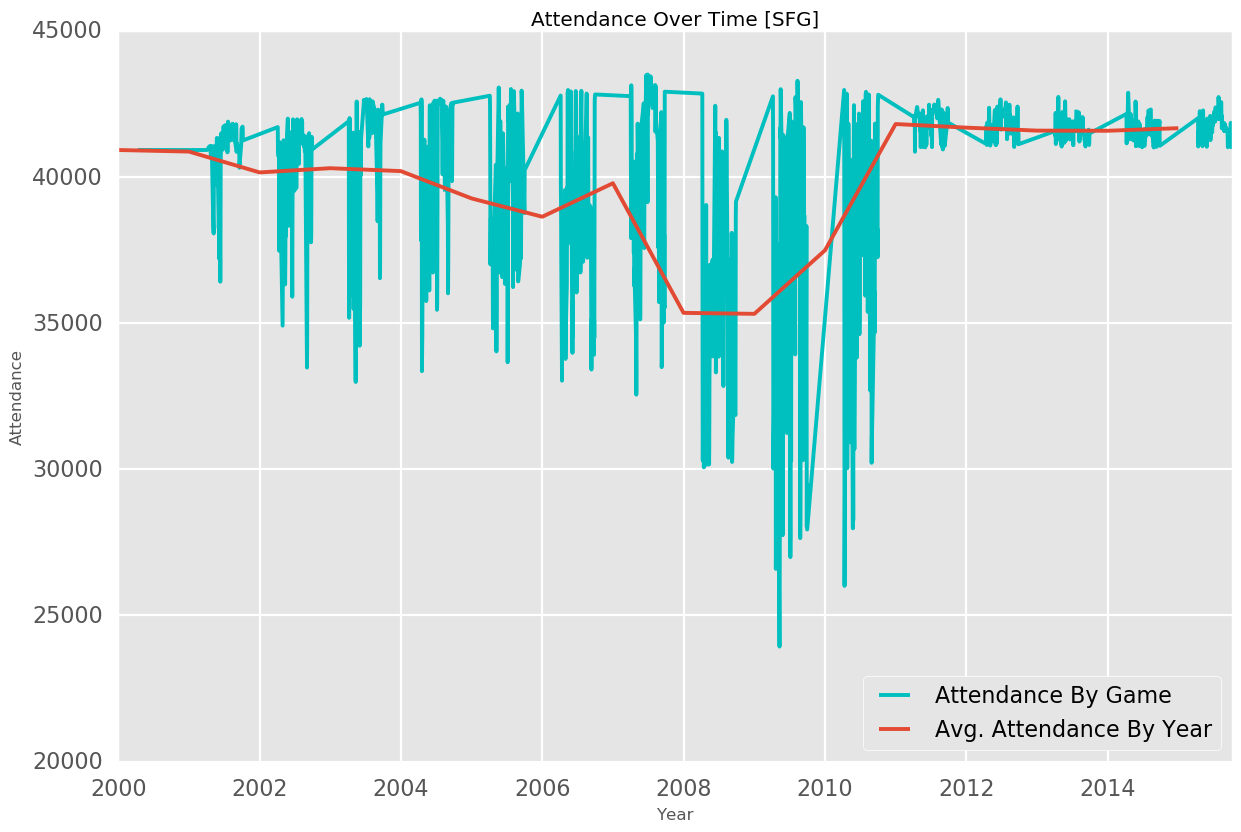

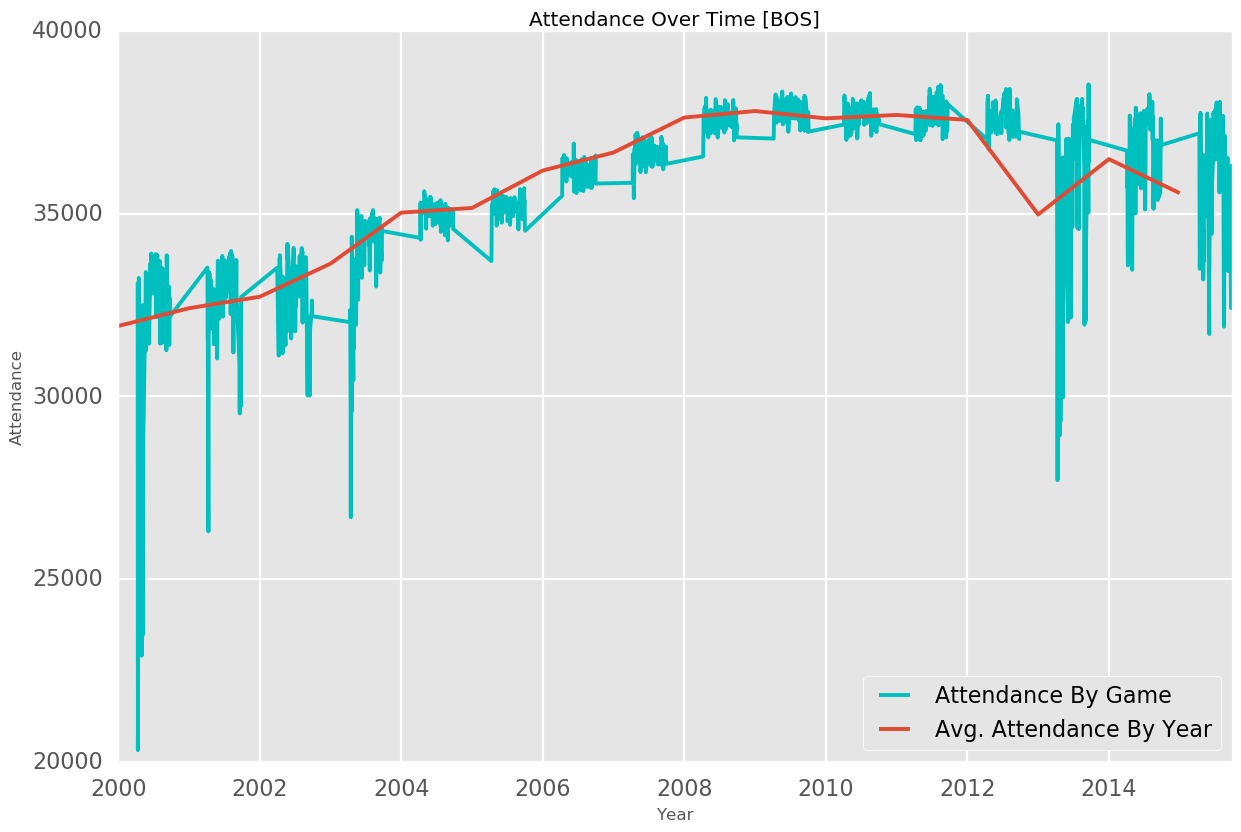

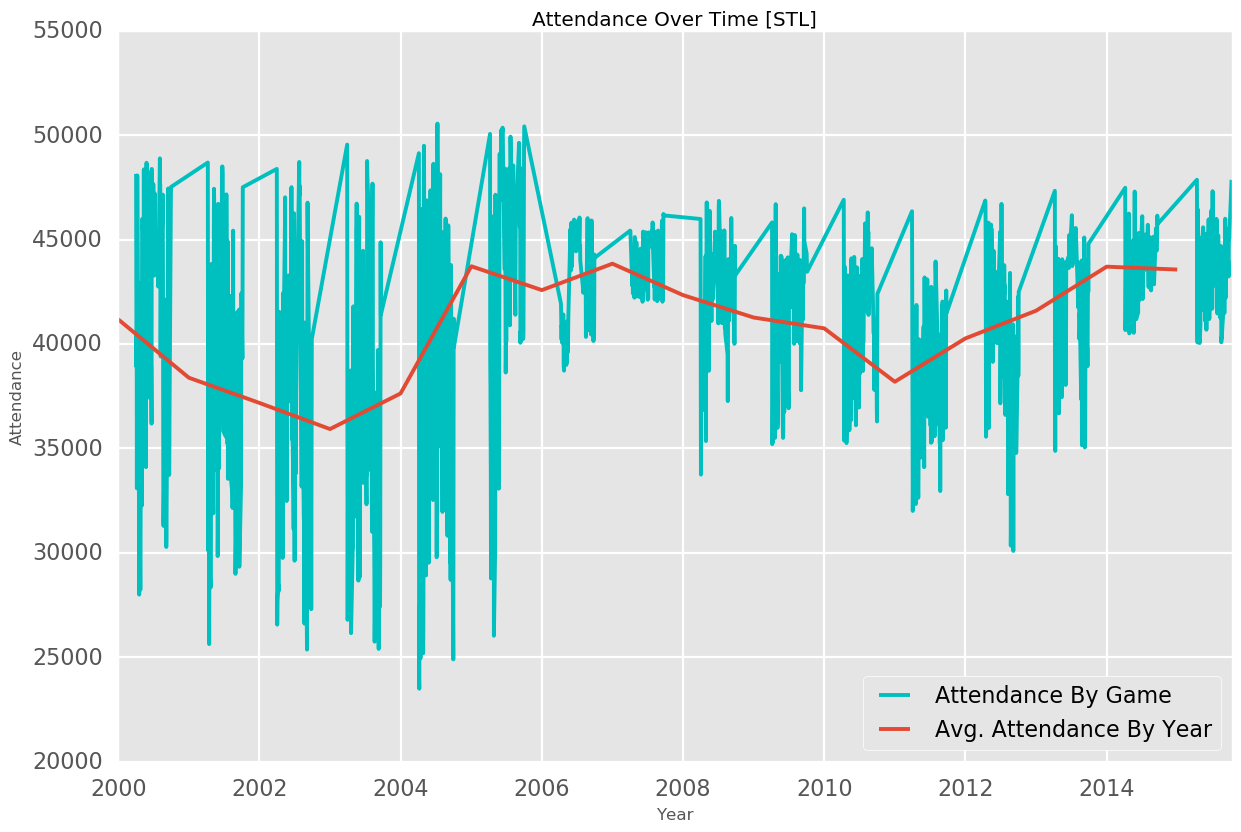

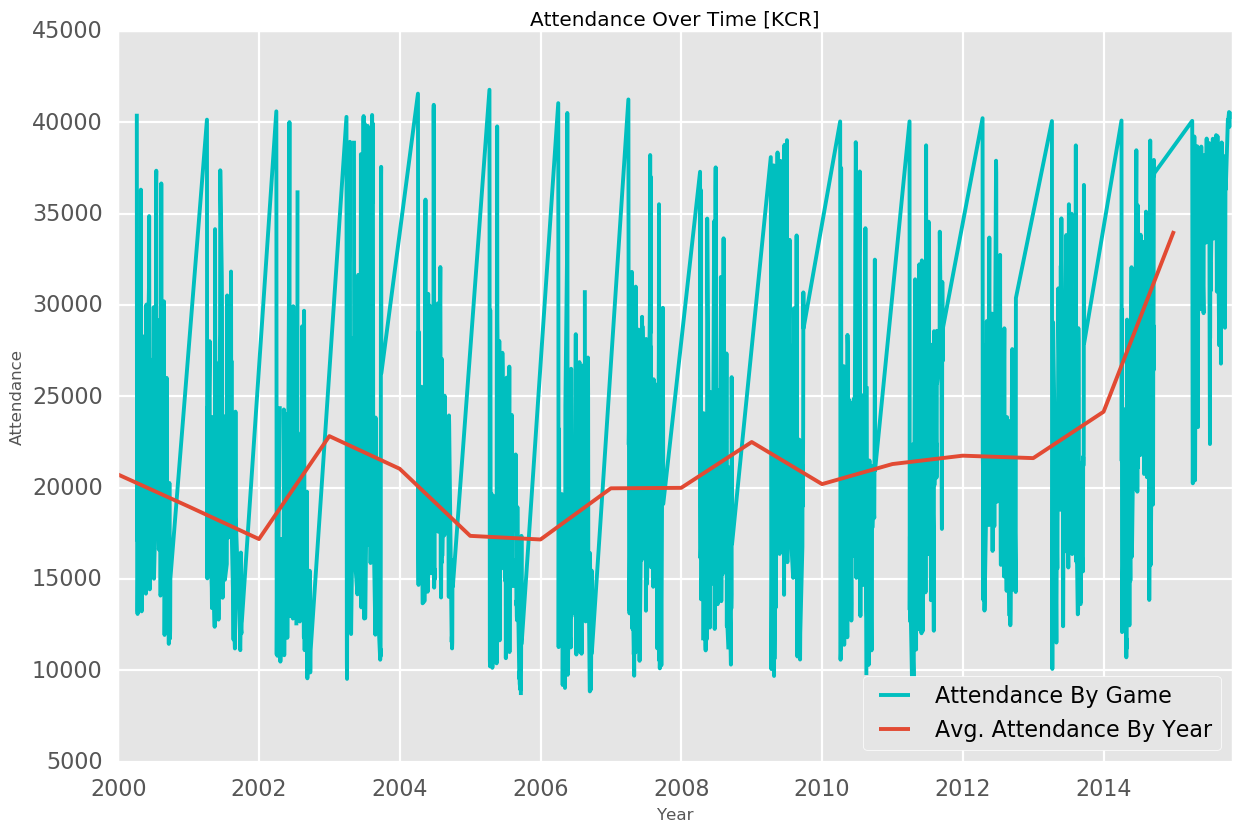

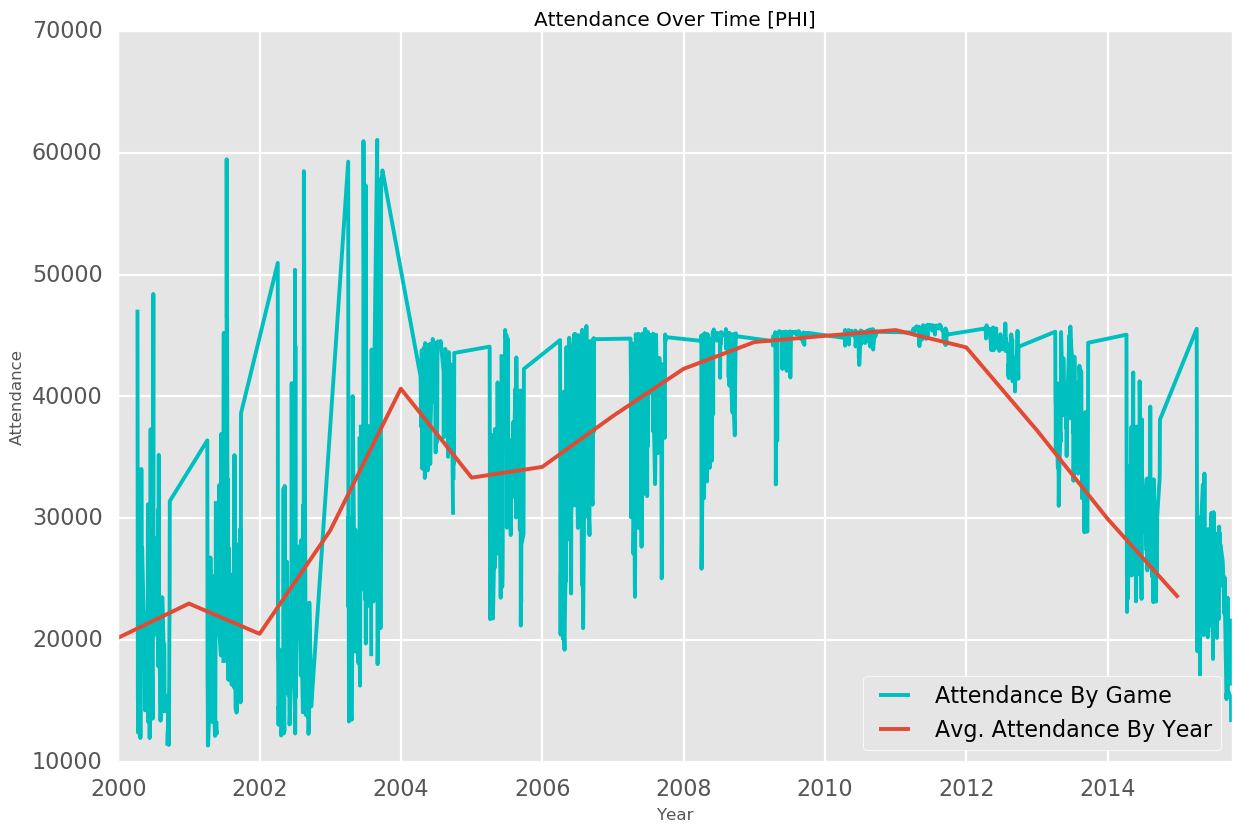

In [266]:
# ATTENDANCE OVER TIME (GROUPED BY MONTHLY AVERAGE)
for team in ["SFG", "BOS", "STL", "KCR", "PHI"]:
    plt.figure()
    att_time_game = teams[team][teams[team]["Home"] != "@"].sort_values("Date")
    plt.style.use("seaborn-poster")
    plt.style.use("ggplot")
    plt.plot(att_time_game["Date"], att_time_game["Attendance"], "c")

    att_time_year = att_time_game.groupby("Year-DT").mean()["Attendance"].to_frame().reset_index()

    plt.plot(att_time_year["Year-DT"], att_time_year["Attendance"])
    plt.ylabel("Attendance")
    plt.xlabel("Year")
    plt.title("Attendance Over Time [" + team + "]")
    plt.legend(["Attendance By Game", "Avg. Attendance By Year"], loc=4)

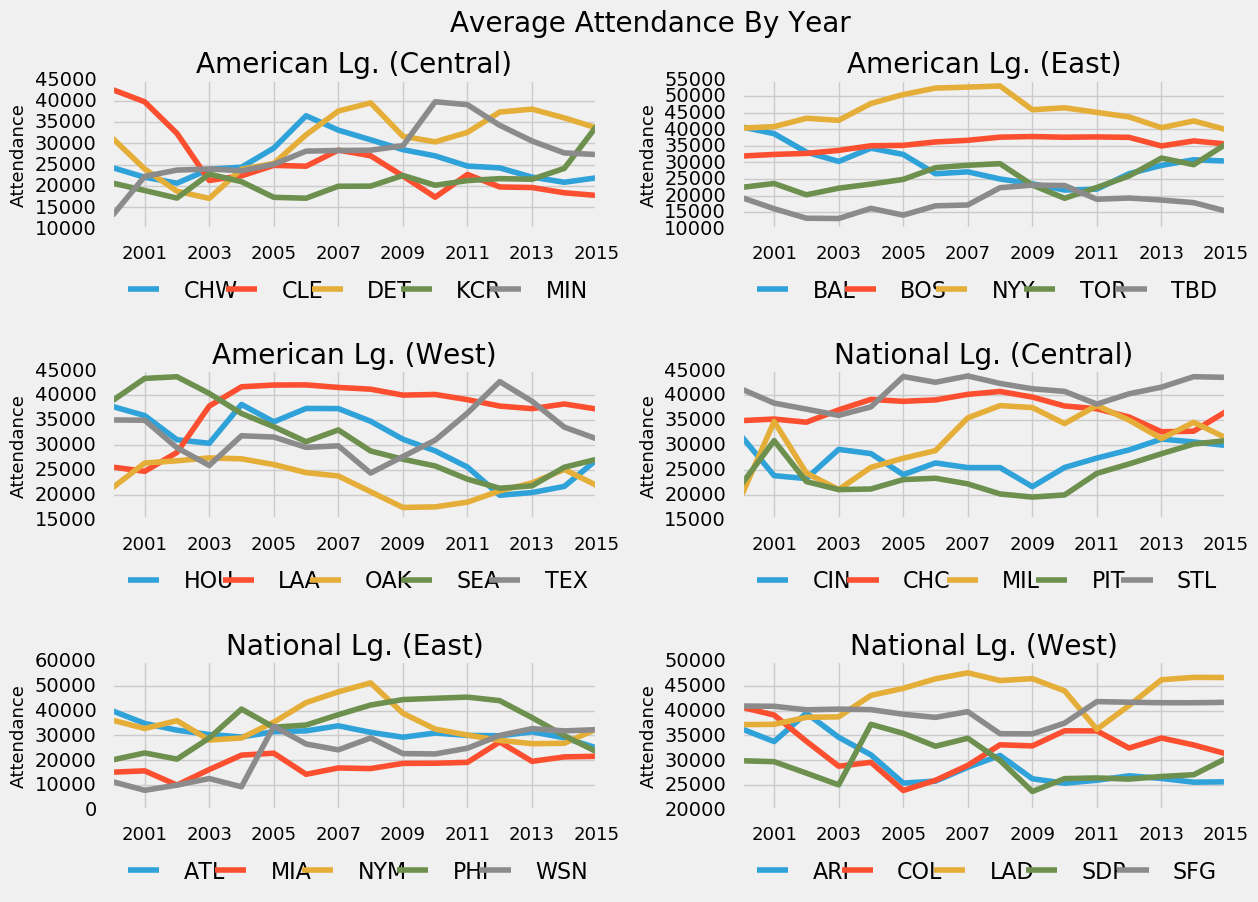

In [37]:
plt.rcParams.update(plt.rcParamsDefault)
plt.style.use("seaborn-poster")
plt.style.use("fivethirtyeight")
plt.rc("ytick", labelsize= 14)
plt.rc("xtick", labelsize= 13)
i = 0
for league in mlb:
    for division in mlb[league]:
        plt.subplot(3, 2, i+1)
        for team in mlb[league][division]:
            att_time_game = teams[team].sort_values("Date")
            att_time_year = att_time_game.groupby("Year-DT").mean()["Attendance"].to_frame().reset_index()
            plt.plot(att_time_year["Year-DT"], att_time_year["Attendance"])

        plt.ylabel("Attendance", fontsize=13)
        plt.title(league + " Lg. (" + division + ")")
        plt.legend(mlb[league][division], bbox_to_anchor=(0.,-.55, 1.,-.55), loc=4, mode="expand", borderaxespad=0., ncol=5)
        i+=1 
plt.suptitle("Average Attendance By Year", fontsize=20)
plt.subplots_adjust(wspace=.3, hspace=.95)
# plt.subplots(figsize=(300, 100))

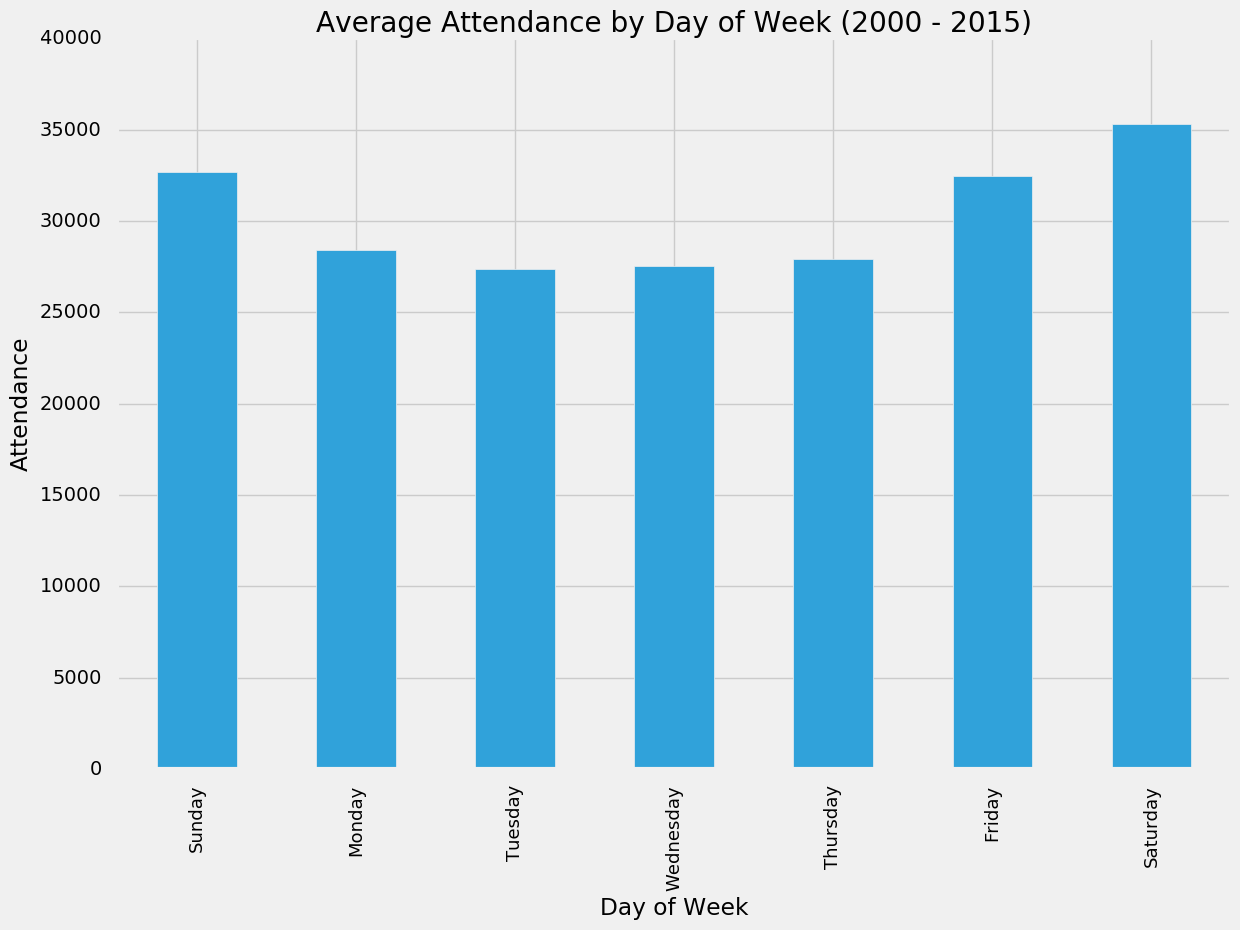

In [38]:
days = ALL.groupby("DOW").mean().reset_index()
    
weekdays = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
mapping = {day: i for i, day in enumerate(weekdays)}
key = days["DOW"].map(mapping)
days = days.iloc[key.argsort()]
      
days.set_index("DOW")["Attendance"].plot.bar()
plt.title("Average Attendance by Day of Week (2000 - 2015)")
plt.ylabel("Attendance")
plt.xlabel("Day of Week")

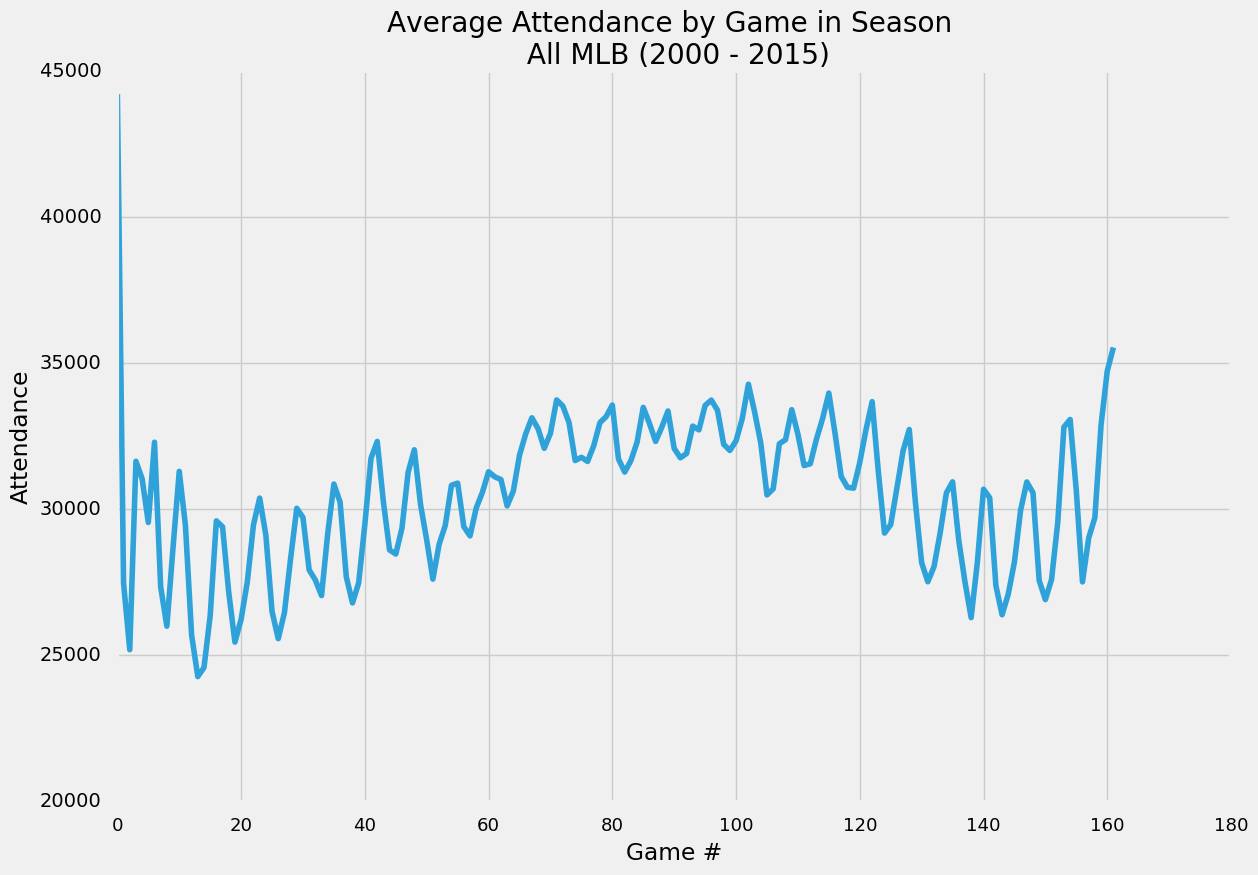

In [39]:
ALL["Game"] = pd.to_numeric(ALL["Game"], errors="coerce")

by_game = ALL.groupby("Game").mean().reset_index()[0:-1]

plt.plot(by_game["Attendance"])
plt.title("Average Attendance by Game in Season \n All MLB (2000 - 2015)")
plt.xlabel("Game #")
plt.ylabel("Attendance")

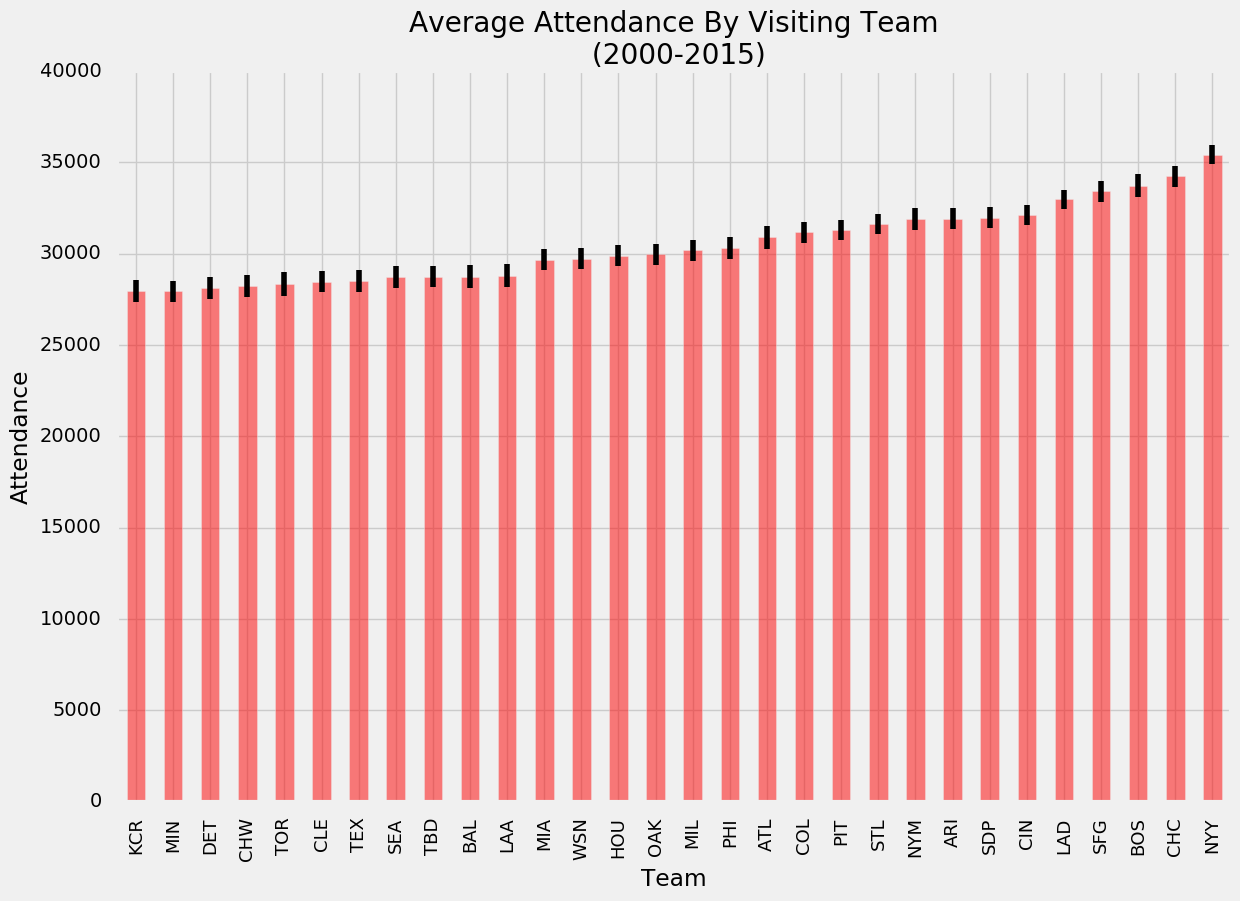

In [40]:
sort = ALL.groupby(["Opp"])["Attendance"]

error = 1.96 * (sort.std() / (sort.count() ** .5))
sort.mean().sort_values().plot.bar(yerr=error, alpha=.5, color='r')
plt.title("Average Attendance By Visiting Team\n (2000-2015)")
plt.xlabel("Team")
plt.ylabel("Attendance")

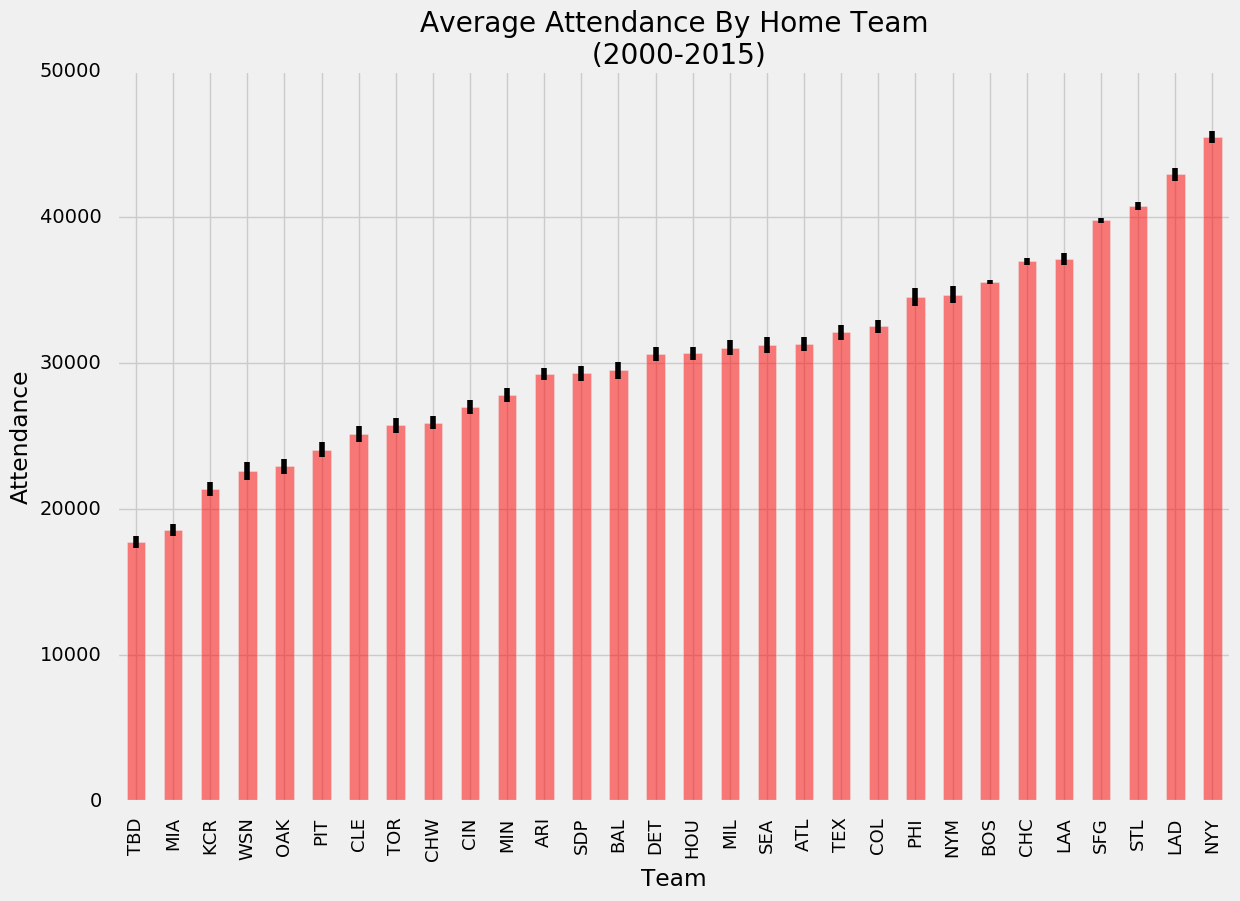

In [41]:
sort = ALL.groupby(["Team"])["Attendance"]

error = 1.96 * (sort.std() / (sort.count() ** .5))
sort.mean().sort_values().plot.bar(yerr=error, alpha=.5, color='r')
plt.title("Average Attendance By Home Team\n (2000-2015)")
plt.xlabel("Team")
plt.ylabel("Attendance")

In [388]:
matchups = {}

# getting the average attendance for every matchup
for away in teams.keys():
    matchups[away] = {}
    for home in teams.keys():
        if away != home:
            temp = teams[home]
            value = temp[temp["Opp"] == away]["Attendance"].mean()
            matchups[away][home] = 0 if math.isnan(value) else value
            
# the average home attendance for every team
home_averages = sort.mean()

effects = {}

for away in matchups.keys():
    for home in teams.keys(): #calculate the diff b/w home_averages[home] and matchups[key][home]
        if home != away:
            diff = matchups[away][home] - home_averages[home]
#             print("---- " + away + " @ " + home + " ----")
#             print(str(matchups[away][home]))
#             print("avg home: " + str(home_averages[home]))
            if away not in effects:
                effects[away] = diff
            else:
                effects[away] += diff

In [389]:
effects = pd.Series(effects, index=teams.keys()).to_frame()
effects.columns = ["Attendance Difference"]
effects["Attendance Difference"] /= 29 
effects = effects.sort_values("Attendance Difference")

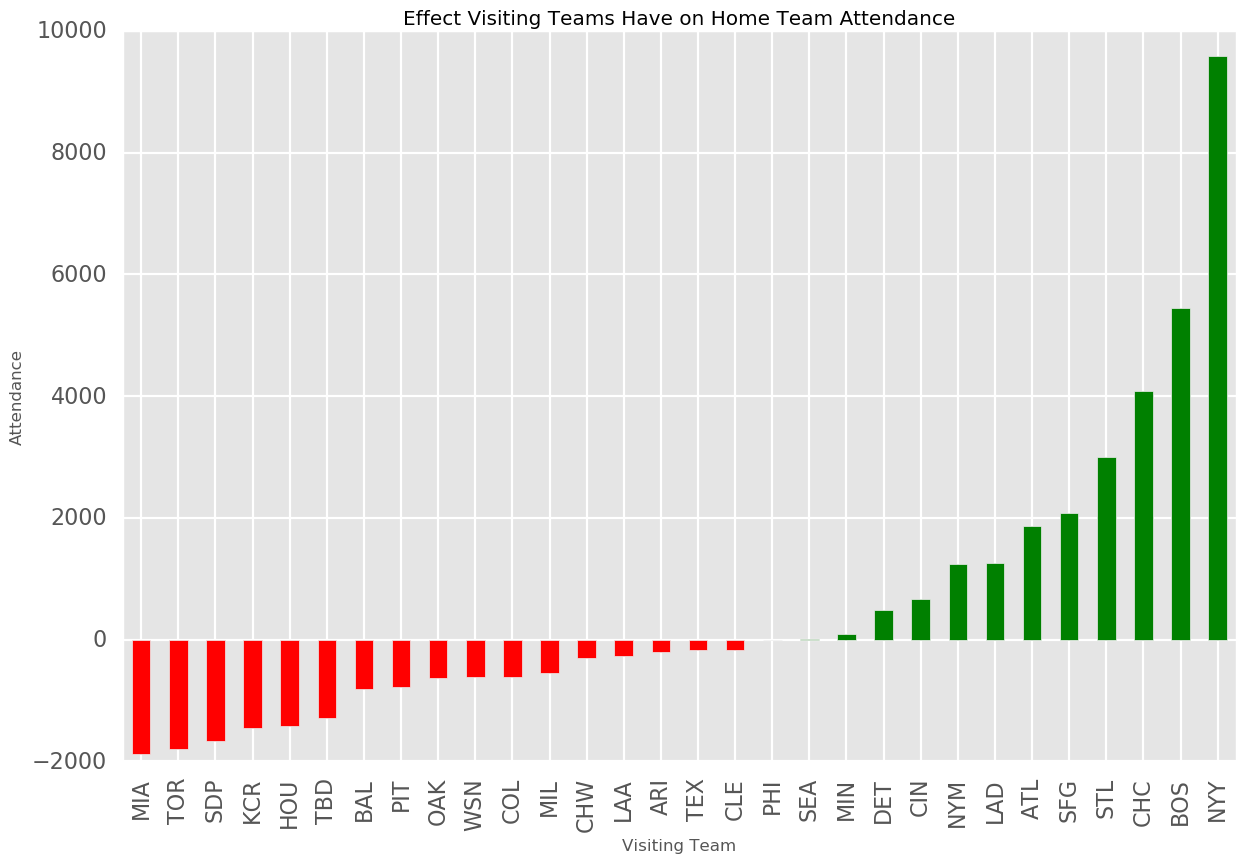

In [390]:
effects["positive"] = effects["Attendance Difference"] >= 0
effects["Attendance Difference"].plot.bar(color=effects.positive.map({True: 'green', False: "red"}))
plt.xlabel("Visiting Team")
plt.ylabel("Attendance")
plt.title("Effect Visiting Teams Have on Home Team Attendance")

In [45]:
ALL_MERGE.columns

Index(['Attendance_x', 'Team_x', 'Opp_x', 'DOW_x', 'GB_x', 'GB_y', 'Month_x',
       'Pitcher_x', 'OPitcher_x', 'Pct_x', 'Pct_y', 'RA_x', 'RS_x', 'Streak_x',
       'Streak_y', 'W/L_x', 'WO_x', 'Game_x', 'Time', 'Date', 'Year_x',
       'RA_Z_x', 'RS_Z_x', 'RA_Z_y', 'RS_Z_y', 'Intra', 'Inter', 'RD',
       'RD_Opp'],
      dtype='object')

In [184]:
data = ALL_MERGE[["GB_x", "GB_y", "Pct_x", "Pct_y", "Streak_x", "Streak_y", "Game_x", "Intra", "Inter", "Attendance_x", "Team_x", "Opp_x", "DOW_x", "Time", "RD", "RD_Opp", "Year_x"]]

In [186]:
data = pd.concat([data, pd.get_dummies(data["Team_x"]).ix[:, 1:30]], axis = 1)
#need to rename columns for team names here

data = pd.concat([data, pd.get_dummies(data["Opp_x"], prefix="_").ix[:, 1:30]], axis = 1)
data = pd.concat([data, pd.get_dummies(data["DOW_x"]).ix[:, 1:7]], axis = 1)
data["Time"] = data["Time"] == True * 1

data = data.apply(pd.to_numeric, errors='coerce').fillna(0)
data = data[data["Attendance_x"] != 0]
ALL_MERGE["Attendance_x"] = pd.to_numeric(ALL_MERGE["Attendance_x"], errors="coerce").fillna(0)
ALL_MERGE = ALL_MERGE[ALL_MERGE["Attendance_x"] != 0]

In [187]:
# from sklearn.tree import DecisionTreeRegressor

# y = ALL_MERGE["Attendance_x"]
# X = data[["GB_x", "GB_y", "Pct_x", "Pct_y", "Streak_x", "Streak_y", "Game_x", "Intra", "Inter"]]

# model = DecisionTreeRegressor(max_depth=5)
# model.fit(X, y)

# from sklearn.tree import export_graphviz
# from sklearn.externals.six import StringIO
# with open("tree.dot", "w") as f:
#         f = export_graphviz(model, out_file=f)

In [193]:
from sklearn import linear_model
from sklearn.cross_validation import cross_val_score

# FOR ALL MLB

y = ALL_MERGE["Attendance_x"]
X = data[["GB_x", "GB_y", "RD", "RD_Opp", "Pct_x", "Pct_y", "Streak_x", "Streak_y", "Game_x", "Intra", \
          "Inter", "Monday", "Tuesday", "Wednesday", "Thursday", "Saturday", "Sunday", "NYY", "MIA", "CHC", \
          "OAK", "SFG", "LAD", "__LAD", "__NYY", "__BOS", "__SFG",
         ]]

model = linear_model.LinearRegression()
model.fit(X, y)

np.sqrt(np.mean(-cross_val_score(model, X, y, cv=10, scoring="mean_squared_error")))

9275.6500618816935

In [247]:
# FOR EACH TEAM (INDIVIDUALLY)

team_errs = pd.DataFrame()

for team in teams.keys():
    if team is not "ARI":
        y = ALL_MERGE[ALL_MERGE["Team_x"] == team]["Attendance_x"]
        X = data[data[team] == 1][["GB_x", "RD", "RD_Opp", "Pct_x", "Pct_y", "Streak_x", "Streak_y", "Game_x", "Intra", \
                  "Inter", "Monday", "Tuesday", "Wednesday", "Thursday", "Saturday", "Sunday", 
                 ]]

        model = linear_model.LinearRegression()
        model.fit(X, y)

        err = np.sqrt(np.mean(-cross_val_score(model, X, y, cv=20, scoring="mean_squared_error")))
        temp = pd.DataFrame()
        temp["Err"] = [err]
        temp["Team"] = [team]
        team_errs = pd.concat([team_errs, temp])

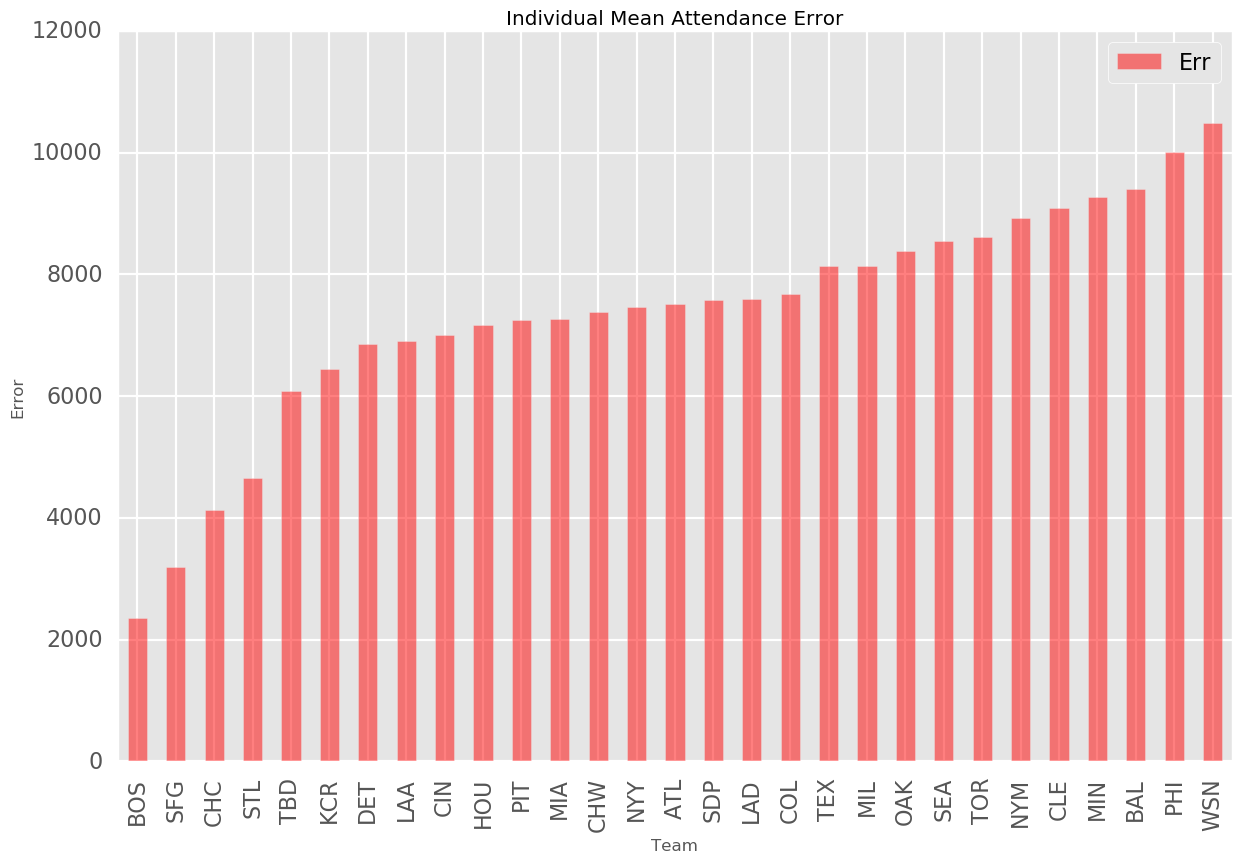

In [258]:
team_errs.groupby(["Team"]).mean().sort_values("Err").plot.bar(alpha=.5, color='r')
plt.title("Individual Mean Attendance Error")
plt.xlabel("Team")
plt.ylabel("Error")

In [380]:
def calculator (team, GB_x, RD, RD_Opp, Pct_x, Pct_y, Streak_x, Streak_y, Game_x, Intra, 
                  Inter, Monday, Tuesday, Wednesday, Thursday, Saturday, Sunday):
    
    y = ALL_MERGE[ALL_MERGE["Team_x"] == team]["Attendance_x"]
    X = data[data[team] == 1][["GB_x", "RD", "RD_Opp", "Pct_x", "Pct_y", "Streak_x", "Streak_y", "Game_x", "Intra", \
              "Inter", "Monday", "Tuesday", "Wednesday", "Thursday", "Saturday", "Sunday", 
             ]]

    model = linear_model.LinearRegression()
    model.fit(X, y)
    c = model.coef_
    
    df = pd.DataFrame({
            "GB_x": [GB_x], 
            "RD": [RD], 
            "RD_Opp": [RD_Opp], 
            "Pct_x": [Pct_x], 
            "Pct_y": [Pct_y], 
            "Streak_x": [Streak_x], 
            "Streak_y": [Streak_y], 
            "Game_x": [Game_x], 
            "Intra": [Intra],
            "Inter": [Inter], 
            "Monday": [Monday], 
            "Tuesday": [Tuesday], 
            "Wednesday": [Wednesday], 
            "Thursday": [Thursday], 
            "Saturday": [Saturday], 
            "Sunday": [Sunday],
        })
    
    return model.predict(df)

In [381]:
                                                              # DOW
calculator("BOS", 0.5, 71, 5, .580, .530, -1, 4, 57, 0, 1,    0, 0, 0, 0, 1, 0)

array([ 39310.90686068])

In [391]:
model.coef_

array([ -3.02613407e+02,  -8.37417247e-10,   3.27418093e-11,
         2.33439691e+04,   1.65736250e+04,  -4.45684809e+01,
         1.95727020e+02,   3.50411105e+01,  -2.27859987e+03,
        -1.85778467e+02,  -6.31468877e+03,  -7.95895522e+03,
        -6.45191126e+03,  -6.04532406e+03,   1.56423956e+03,
         9.48633625e+02])

In [404]:
                                                              # DOW
calculator("TOR", 0.5, 71, 5, .580, .530, -1, 4, 57, 0, 1,    0, 0, 0, 0, 1, 0)

array([ 26644.00641711])

In [402]:
model.coef_

array([ -3.02613407e+02,  -8.37417247e-10,   3.27418093e-11,
         2.33439691e+04,   1.65736250e+04,  -4.45684809e+01,
         1.95727020e+02,   3.50411105e+01,  -2.27859987e+03,
        -1.85778467e+02,  -6.31468877e+03,  -7.95895522e+03,
        -6.45191126e+03,  -6.04532406e+03,   1.56423956e+03,
         9.48633625e+02])